OK, to begin we need to import some standart Python modules

In [62]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 12 13:21:45 2016

@author: GrinevskiyAS
"""

from __future__ import division
import numpy as np
from numpy import sin,cos,tan,pi,sqrt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline


font = {'family': 'Arial', 'weight': 'normal', 'size':14}
mpl.rc('font', **font)

First, let us setup the working area.

In [81]:
#This would be the size of each grid cell (X is the spatial coordinate, T is two-way time)
xstep=10
tstep=10

#size of the whole grid
xmax = 301
tmax = 201

#that's the arrays of x and t
xarray=np.arange(0, xmax, xstep)    
tarray=np.arange(0, tmax, tstep)

#now fimally we created a 2D array img, which is now all zeros, but later we will add some amplitudes there
img=np.zeros((len(xarray), len(tarray)))

Let's show our all-zero image

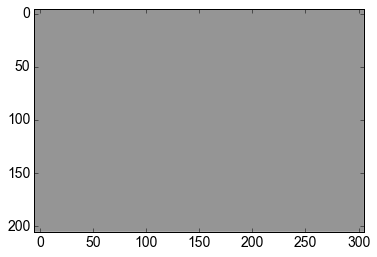

In [82]:
plt.imshow(img.T,interpolation='none',cmap=cm.Greys, vmin=-2,vmax=2, extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])

What we are now going to do is create a class named **`Hyperbola`**

Each object of this class is capable of computing traveltimes to a certain subsurface point (diffractor) and plotting this point response on a grid


In [64]:
class Hyperbola:
    def __init__(self, xarray, tarray, x0, v, t0):
        ###input parameters define a difractor's position (x0,t0), P-wave velocity of homogeneous subsurface, and x- and t-arrays to compute traveltimes on.
        ###
        
        self.x=xarray
        self.x0=x0
        self.t0=t0
        self.v=v
        
        #compute traveltimes
        self.t=sqrt(t0**2 + (2*(xarray-x0)/v)**2)
        
        #obtain some grid parameters
        xstep=xarray[1]-xarray[0]
        tbegin=tarray[0]
        tend=tarray[-1]
        tstep=tarray[1]-tarray[0]
        
        #delete t's and x's for samples where t exceeds maxt
        self.x=self.x[ (self.t>=tbegin) & (self.t <= tend) ]        
        self.t=self.t[ (self.t>=tbegin) & (self.t <= tend) ]
        self.imgind=((self.x-xarray[0])/xstep).astype(int)       
        
        #compute amplitudes' fading according to geometrical spreading
        self.amp = 1/(self.t/self.t0)
        
        self.grid_resample(xarray, tarray)
        
    
    def grid_resample(self, xarray, tarray):
    # that's a function that computes at which 'cells' of image should we place the hyperbola
    
        tend=tarray[-1]
        tstep=tarray[1]-tarray[0]
        
        self.xind=((self.x-xarray[0])/xstep).astype(int)  #X cells numbers
        
        self.tind=np.round((self.t-tarray[0])/tstep).astype(int) #T cells numbers
        self.tind=self.tind[self.tind*tstep<=tarray[-1]] #delete T's exceeding max.T
        
        self.tgrid=tarray[self.tind] # get 'gridded' T-values
        
        self.coord=np.vstack((self.xind,tarray[self.tind]))    
        
            
    def add_to_img(self, img, wavelet):
    # puts the hyperbola into the right cells of image with a given wavelet
        maxind=np.size(img,1)        
        wavlen=np.floor(len(wavelet)/2).astype(int)      
        
        self.imgind=self.imgind[self.tind < maxind-1]        
        self.tind=self.tind[self.tind < maxind-1]
        ind_begin=self.tind-wavlen                
        

        for i,sample in enumerate(wavelet):
                img[self.imgind,ind_begin+i]=img[self.imgind,ind_begin+i]+sample
        return img

For testing purposes, let's create an object named Hyp_test and view its parameters

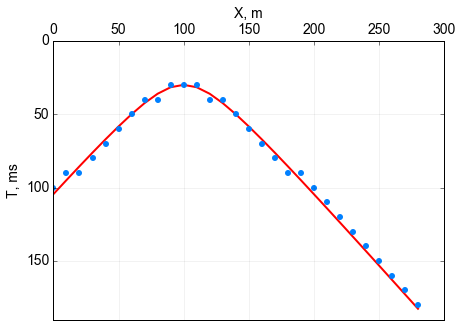

In [78]:
Hyp_test = Hyperbola(xarray, tarray, x0 = 100, t0 = 30, v = 2)

#Create a fugure and add axes to it
fgr_test1 = plt.figure(figsize=(7,5), facecolor='w')
ax_test1 = fgr_test1.add_subplot(111)

#Now plot Hyp_test's parameters: X vs T
ax_test1.plot(Hyp_test.x, Hyp_test.t, 'r', lw = 2)
#and their 'gridded' equivalents
ax_test1.plot(Hyp_test.x, Hyp_test.tgrid, ls='none', marker='o', ms=6, mfc=[0,0.5,1],mec='none')

#Some commands to add gridlines, change the directon of T axis and move x axis to top
ax_test1.set_ylim(tarray[-1],tarray[0])
ax_test1.xaxis.set_ticks_position('top')
ax_test1.grid(True, alpha = 0.1, ls='-',lw=.5)

ax_test1.set_xlabel('X, m')
ax_test1.set_ylabel('T, ms')
ax_test1.xaxis.set_label_position('top')

plt.show()